In [1]:
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import learning_curve,RepeatedKFold

from sklearn.pipeline import make_pipeline
from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError

from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn import metrics
from sklearn.externals import joblib
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from scipy import stats
from scipy.special import boxcox1p
from sklearn.svm import SVR,LinearSVR

from sklearn.feature_selection import SelectFromModel
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer,quantile_transform,PowerTransformer
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler

from sklearn.manifold import TSNE

%matplotlib inline

In [2]:

#dataframe final
df_final = pd.read_csv("../data/DF_train15noChangeContact_skempiAB_modeller_final.csv",index_col=0)


pdb_names = df_final.index
features_names = df_final.drop('ddG_exp',axis=1).columns
df_final.shape

(1392, 78)

In [3]:
# Split train and independent test data

X_train, X_test, y_train, y_test = train_test_split(df_final.drop('ddG_exp',axis=1), df_final['ddG_exp'], 
                                                    test_size=0.2, random_state=13)                                               

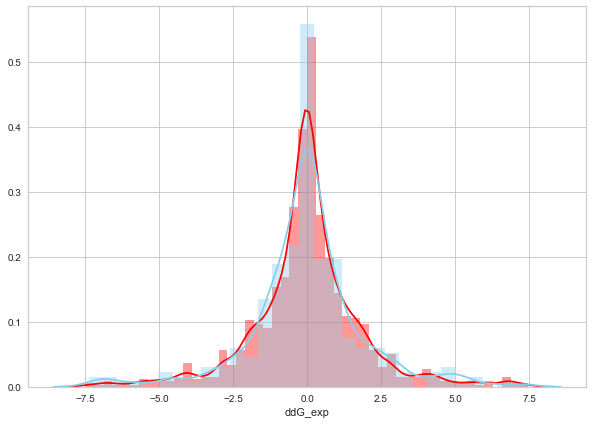

In [4]:
f, ax = plt.subplots(figsize=(10, 7))

sns.distplot(y_train, color="red", label="ddG_exp_train");
sns.distplot(y_test, color="skyblue", label="ddG_exp_test");



 mu = 0.00 and sigma = 1.88



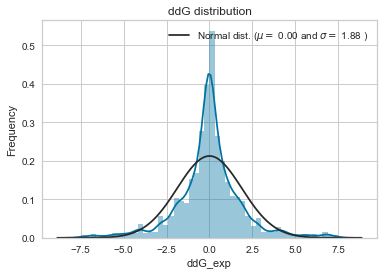

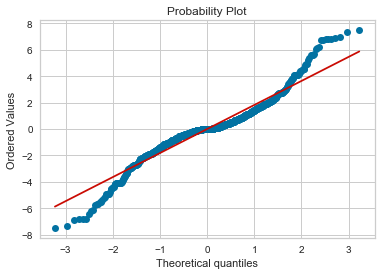

In [5]:
sns.distplot(y_train, fit=stats.norm);

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(y_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('ddG distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

# probably need to transform target variable

## Correlation

In [6]:
# join train data for Exploratory analisis of training data
train = X_train.join(y_train)

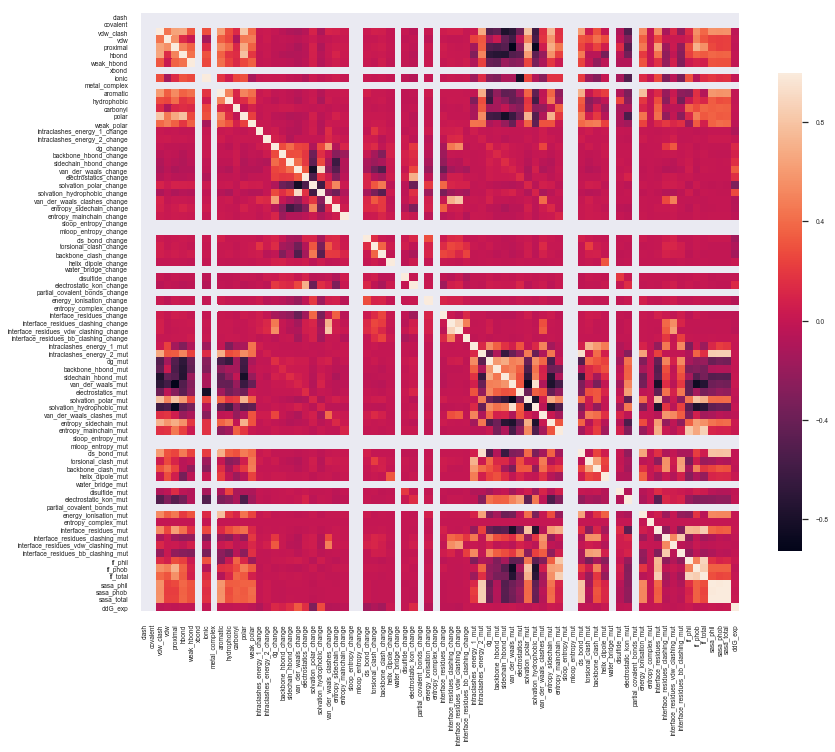

In [7]:
sns.set(font_scale=0.6)

#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(14, 11))
sns.heatmap(corrmat, square=True,cbar_kws={"shrink": .8});

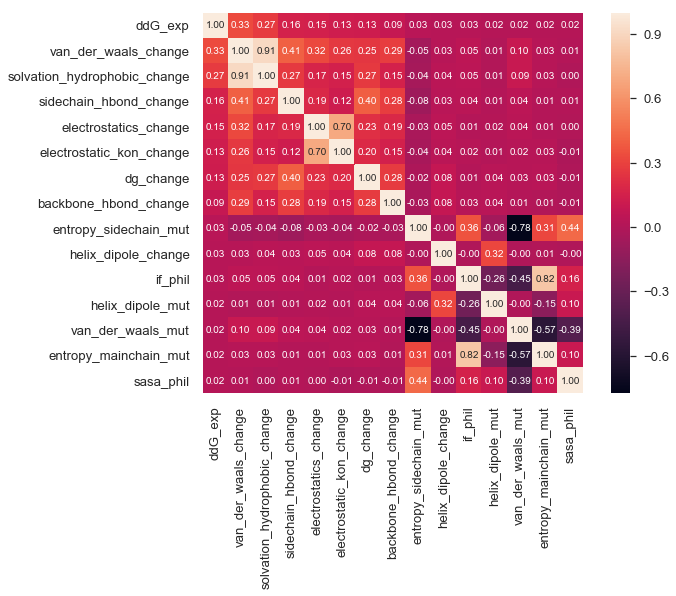

In [8]:
sns.set(font_scale=1.2)


#top 10. correlation matrix
k = 15 #number of variables for heatmap
cols = corrmat.nlargest(k, 'ddG_exp')['ddG_exp'].index
cm = np.corrcoef(train[cols].values.T)

f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values);
#plt.show()

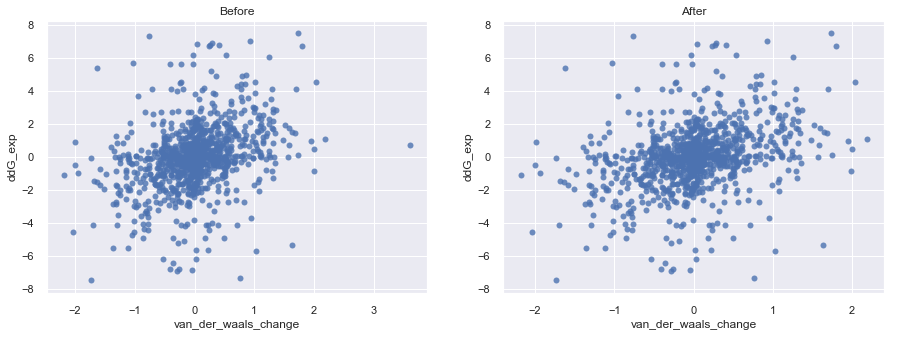

In [9]:
sns.set(font_scale=1)

plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
g = sns.regplot(x=train['van_der_waals_change'], y=train['ddG_exp'], fit_reg=False).set_title("Before")

# Delete outliers
plt.subplot(1, 2, 2)                                                                                
train = train.drop(train[(train['van_der_waals_change']>3)].index)
g = sns.regplot(x=train['van_der_waals_change'], y=train['ddG_exp'], fit_reg=False).set_title("After")

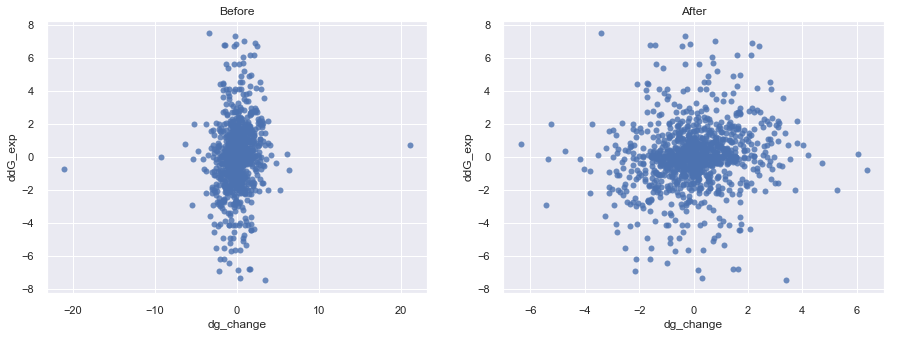

In [10]:
sns.set(font_scale=1)

plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
g = sns.regplot(x=train['dg_change'], y=train['ddG_exp'], fit_reg=False).set_title("Before")

# Delete outliers
plt.subplot(1, 2, 2)                                                                                
train = train.drop(train[(train['dg_change'].abs()>8)].index)
g = sns.regplot(x=train['dg_change'], y=train['ddG_exp'], fit_reg=False).set_title("After")

### NO missing values, skip this dataprocess

## 

### Feature engeenering, checking interaction of sift contact with the highest correlated energetic feature
In order to treat this dataset, first I will check if adding interactions betwen some features improve corr, next i will check for skewess features. Finally i will write a custom transform class for every step.

In [11]:
y_train = train['ddG_exp']
X_train = train.drop('ddG_exp',axis=1)

### Check corr of new features


In [12]:
features_interaction_contactVDW = X_train.iloc[:,:15].mul(X_train["van_der_waals_change"],axis=0)# funciona mucho mejor
features_interaction_contactVDW.columns = features_interaction_contactVDW.columns.str[:]+"_vdw_change_interaction"


In [13]:
corr_matrix = features_interaction_contactVDW.corrwith(y_train,axis=0)#.abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
print(corr_matrix.sort_values(ascending=False).round(6))

hbond_vdw_change_interaction            0.364546
polar_vdw_change_interaction            0.349457
weak_polar_vdw_change_interaction       0.347648
vdw_clash_vdw_change_interaction        0.346148
weak_hbond_vdw_change_interaction       0.341377
proximal_vdw_change_interaction         0.331598
hydrophobic_vdw_change_interaction      0.295767
vdw_vdw_change_interaction              0.295753
ionic_vdw_change_interaction            0.252295
aromatic_vdw_change_interaction         0.239054
carbonyl_vdw_change_interaction         0.209229
clash_vdw_change_interaction                 NaN
covalent_vdw_change_interaction              NaN
xbond_vdw_change_interaction                 NaN
metal_complex_vdw_change_interaction         NaN
dtype: float64


### Check skewness

In [14]:
skew_features = X_train.skew().sort_values(ascending=False)
skew_features

interface_residues_vdw_clashing_mut      6.886928
cis_bond_mut                             2.963595
intraclashes_energy_2_mut                2.953448
interface_residues_bb_clashing_mut       2.902191
interface_residues_clashing_mut          2.566482
sasa_phob                                1.963085
sasa_total                               1.942088
energy_ionisation_mut                    1.862720
sasa_phil                                1.838843
van_der_waals_clashes_change             1.638112
torsional_clash_mut                      1.624876
aromatic                                 1.595366
if_phil                                  1.488984
carbonyl                                 1.362180
entropy_mainchain_mut                    1.285913
vdw_clash                                1.281802
van_der_waals_clashes_mut                1.218391
if_total                                 1.164993
intraclashes_energy_1_mut                1.084688
energy_ionisation_change                 0.826565


### Check features by percetange of zero values

In [15]:
overfit = []
for i in X_train.columns:
    counts = X_train[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X_train) * 100 >90.:
        overfit.append(i)
overfit

['clash',
 'covalent',
 'xbond',
 'metal_complex',
 'sloop_entropy_change',
 'mloop_entropy_change',
 'cis_bond_change',
 'water_bridge_change',
 'partial_covalent_bonds_change',
 'entropy_complex_change',
 'interface_residues_clashing_change',
 'interface_residues_vdw_clashing_change',
 'interface_residues_bb_clashing_change',
 'sloop_entropy_mut',
 'mloop_entropy_mut',
 'water_bridge_mut',
 'partial_covalent_bonds_mut',
 'entropy_complex_mut',
 'interface_residues_vdw_clashing_mut']

### make custom transformers for preprocess in pipeline

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeaturesInteractions(BaseEstimator, TransformerMixin):
    
    #Class constructor method that takes ..
    def __init__(self, interaction1, interaction2 ):
        self.interaction1 = interaction1
        self.interaction2 = interaction2
        
    #Return self nothing else to do here
    def fit( self, X, y = None  ):
        
        return self
    
    def transform(self, X , y=None ):
        
        X_interactions = X.loc[:,self.interaction1].mul(X[self.interaction2],axis=0)
        X_interactions.columns = X_interactions.columns.values+'/{}'.format(self.interaction2)
        # set columns names
        
        X = X.join(X_interactions)
        
        return X
    
class SkewTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, threshold=0.6, method='quantile'):
        self.threshold = threshold
        self.method = method
        
    #Return self nothing else to do here
    def fit(self, X, y = None  ):
        skewes_ = X.skew().sort_values(ascending=False)
        self.skew_features = skewes_[skewes_.abs() > self.threshold]
        
        if self.method == 'quantile':
            self.t = QuantileTransformer(output_distribution="normal",random_state=13)
            self.t.fit(X[self.skew_features.index])
        
        return self
    
    def transform(self, X, y=None):
        
        X[self.skew_features.index] = self.t.transform(X[self.skew_features.index])
        
        return X
        
class ZeroThreshold(BaseEstimator, TransformerMixin):
    
    def __init__(self, threshold=90.):
        self.threshold = threshold
    
    
    def fit(self, X, y = None  ):
        
        self.feature_names = X.columns
        self.overfit = []
        for i in X.columns:
            counts = X[i].value_counts()
            zeros = counts.iloc[0]
            if zeros / len(X) * 100 >self.threshold:
                self.overfit.append(i)
        
        return self
    
    def transform(self, X, y=None):
        
        X.drop(self.overfit,axis=1,inplace=True)
        
        return X

# Modeling

In [13]:

X_train.shape,y_train.shape,X_test.shape,y_test.shape

((1109, 77), (1109,), (279, 77), (279,))

In [43]:
LinearSVR?

In [27]:
#1)  ORIGINAL
## Pipeline preprocessing
interactions = FeaturesInteractions(interaction1=X_train.columns[:15].tolist(),interaction2="van_der_waals_change")
skewness = SkewTransformer(threshold=0.6,method='quantile')
zeroth = ZeroThreshold(threshold=90.)

scaler = MinMaxScaler()

#2)
linear_model = LinearSVR(max_iter=50000)
#3) Crear pipeline
pipeline1 = make_pipeline(interactions,skewness,zeroth,scaler,linear_model)

# Use transformed target regressor
# regr_trans = TransformedTargetRegressor(regressor=pipeline1, 
#                                         transformer=QuantileTransformer(output_distribution='normal',random_state=13))


# grid params
# param_grid = { 'regressor__linearsvr__C': [0.7,0.6,0.5] , 'regressor__linearsvr__epsilon':[0.2,0.3,0.4],
#               'regressor__linearsvr__random_state': [1313],'regressor__linearsvr__fit_intercept':[True]}
param_grid = { 'linearsvr__C': [8] , 'linearsvr__epsilon':[0.01],
              'linearsvr__random_state': [1313],'linearsvr__fit_intercept':[False,True]}
cv = RepeatedKFold(n_splits=10,n_repeats=10,random_state=13)

# Instantiate the grid search model
grid1 = GridSearchCV(pipeline1, param_grid, verbose=5, n_jobs=-1,cv=cv,scoring=['neg_mean_squared_error','r2'],
                        refit='neg_mean_squared_error',return_train_score=True)

grid1.fit(X_train,y_train)

Fitting 100 folds for each of 2 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   19.7s finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x1a1d0387f0>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('featuresinteractions', FeaturesInteractions(interaction1=['clash', 'covalent', 'vdw_clash', 'vdw', 'proximal', 'hbond', 'weak_hbond', 'xbond', 'ionic', 'metal_complex', 'aromatic', 'hydrophobic', 'carbonyl', 'polar', 'weak_polar'],
           interaction2='van_der_waals_change')), ('skewtra...ng=1.0, loss='epsilon_insensitive', max_iter=50000,
     random_state=None, tol=0.0001, verbose=0))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'linearsvr__C': [8], 'linearsvr__epsilon': [0.01], 'linearsvr__random_state': [1313], 'linearsvr__fit_intercept': [False, True]},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score=True, scoring=['neg_mean_squared_error', 'r2'],
       verbose=5)

In [28]:
# index of best scores
rmse_bestCV_test_index = grid1.cv_results_['mean_test_neg_mean_squared_error'].argmax()
rmse_bestCV_train_index = grid1.cv_results_['mean_train_neg_mean_squared_error'].argmax()
r2_bestCV_test_index = grid1.cv_results_['mean_test_r2'].argmax()
r2_bestCV_train_index = grid1.cv_results_['mean_train_r2'].argmax()
# scores
rmse_bestCV_test_score = grid1.cv_results_['mean_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_test_std = grid1.cv_results_['std_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_train_score = grid1.cv_results_['mean_train_neg_mean_squared_error'][rmse_bestCV_train_index]
rmse_bestCV_train_std = grid1.cv_results_['std_train_neg_mean_squared_error'][rmse_bestCV_train_index]

r2_bestCV_test_score = grid1.cv_results_['mean_test_r2'][r2_bestCV_test_index]
r2_bestCV_test_std = grid1.cv_results_['std_test_r2'][r2_bestCV_test_index]
r2_bestCV_train_score = grid1.cv_results_['mean_train_r2'][r2_bestCV_train_index]
r2_bestCV_train_std = grid1.cv_results_['std_train_r2'][r2_bestCV_train_index]

print('CV test RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_test_score),np.sqrt(rmse_bestCV_test_std)))
print('CV train RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_train_score),np.sqrt(rmse_bestCV_train_std)))
print('DIFF RMSE {}'.format(np.sqrt(-rmse_bestCV_test_score)-np.sqrt(-rmse_bestCV_train_score)))
print('CV test r2 {:f} +/- {:f}'.format(r2_bestCV_test_score,r2_bestCV_test_std))
print('CV train r2 {:f} +/- {:f}'.format(r2_bestCV_train_score,r2_bestCV_train_std))

print(r2_bestCV_train_score-r2_bestCV_test_score)
print("",grid1.best_params_)
y_test_pred = grid1.best_estimator_.predict(X_test)
y_train_pred = grid1.best_estimator_.predict(X_train)
print("\nRMSE for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)))
print("RMSE for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)))
print("pearson corr  {:f}".format(np.corrcoef(y_test_pred,y_test.values.ravel())[0][1]))
print('R2 test',r2_score(y_test,y_test_pred))
print('R2 train',r2_score(y_train,y_train_pred))

CV test RMSE 1.735564 +/- 0.834876
CV train RMSE 1.676575 +/- 0.272977
DIFF RMSE 0.058989374239400316
CV test r2 0.141063 +/- 0.083939
CV train r2 0.204807 +/- 0.010242
0.0637442160902989
 {'linearsvr__C': 8, 'linearsvr__epsilon': 0.01, 'linearsvr__fit_intercept': True, 'linearsvr__random_state': 1313}

RMSE for test dataset: 1.74
RMSE for train dataset: 1.68
pearson corr  0.511054
R2 test 0.23765968955151828
R2 train 0.2063162243575004


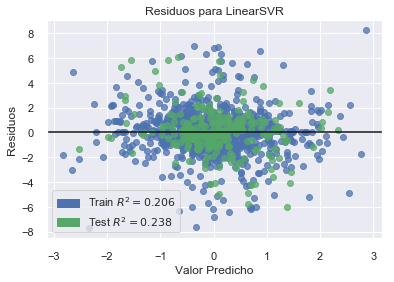

In [29]:
visualizer = ResidualsPlot(grid1.best_estimator_,title='Residuos para LinearSVR',hist=False)

visualizer.fit(X_train, y_train.values.ravel())  # Fit the training data to the model
visualizer.score(X_test, y_test.values.ravel())  # Evaluate the model on the test data

visualizer.finalize()
visualizer.ax.set_xlabel('Valor Predicho')
visualizer.ax.set_ylabel('Residuos')

plt.savefig("LinearSVR_R2_train15.png",dpi=600,bbox_inches="tight")

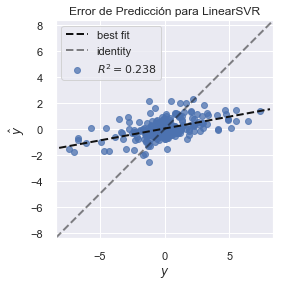

In [30]:
perror = PredictionError(grid1.best_estimator_, title='Error de Predicción para LinearSVR')

perror.fit(X_train, y_train.values.ravel())  # Fit the training data to the visualizer
perror.score(X_test, y_test.values.ravel())  # Evaluate the model on the test data

perror.finalize()
plt.savefig("LinearSVR_PredictionError_train15.png",dpi=600,bbox_inches="tight")

#g = perror.poof()

In [31]:
full_data = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

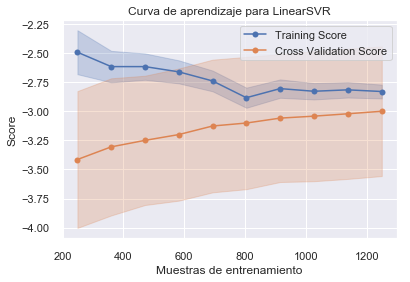

In [32]:
viz = LearningCurve(grid1.best_estimator_, cv=cv, n_jobs=-1,scoring='neg_mean_squared_error',
                    train_sizes=np.linspace(0.2, 1.0, 10),title='Curva de aprendizaje para LinearSVR')
viz.fit(full_data, y_full)

viz.finalize()

viz.ax.set_xlabel('Muestras de entrenamiento')
viz.ax.set_ylabel('Score')

plt.savefig("LinearSVR_LearningCurve_train15.png",dpi=600,bbox_inches="tight")

#viz.poof()

In [33]:
print("RMSE CV Train {}".format(np.sqrt(-viz.train_scores_mean_[-1])))
print("RMSE CV Test {}".format(np.sqrt(-viz.test_scores_mean_[-1])))

RMSE CV Train 1.6819273395344332
RMSE CV Test 1.7317265551602086


# SVR poly, rbf kernel gridsearch

In [36]:
SVR?

In [76]:
#1)  ORIGINAL

## Pipeline preprocessing
interactions = FeaturesInteractions(interaction1=X_train.columns[:15].tolist(),interaction2="van_der_waals_change")
skewness = SkewTransformer(threshold=0.6,method='quantile')
zeroth = ZeroThreshold(threshold=90.)

scaler = MinMaxScaler()

#2)
linear_model = SVR()
#3) Crear pipeline
pipeline2 = make_pipeline(interactions,skewness,zeroth,scaler,linear_model)

# Use transformed target regressor
regr_trans2 = TransformedTargetRegressor(regressor=pipeline2, 
                                        transformer=QuantileTransformer(output_distribution='normal',random_state=13))


# grid params
# param_grid = { 'regressor__svr__kernel': ['rbf'],'regressor__svr__C': [1.5],'regressor__svr__gamma': [0.8],
#               'regressor__svr__epsilon':[0.3]}
param_grid = { 'svr__kernel': ['rbf'],'svr__C': [2.5],'svr__gamma': [0.5],
              'svr__epsilon':[0.5]}

cv = RepeatedKFold(n_splits=10,n_repeats=10,random_state=13)

# Instantiate the grid search model
grid2 = GridSearchCV(pipeline2, param_grid, verbose=5, n_jobs=-1,cv=cv,scoring=['neg_mean_squared_error','r2'],
                        refit='neg_mean_squared_error',return_train_score=True)

grid2.fit(X_train,y_train)

Fitting 100 folds for each of 1 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  90 out of 100 | elapsed:    7.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.0s finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x1a1af45be0>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('featuresinteractions', FeaturesInteractions(interaction1=['clash', 'covalent', 'vdw_clash', 'vdw', 'proximal', 'hbond', 'weak_hbond', 'xbond', 'ionic', 'metal_complex', 'aromatic', 'hydrophobic', 'carbonyl', 'polar', 'weak_polar'],
           interaction2='van_der_waals_change')), ('skewtra...
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'svr__kernel': ['rbf'], 'svr__C': [2.5], 'svr__gamma': [0.5], 'svr__epsilon': [0.5]},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score=True, scoring=['neg_mean_squared_error', 'r2'],
       verbose=5)

In [77]:
# index of best scores
rmse_bestCV_test_index = grid2.cv_results_['mean_test_neg_mean_squared_error'].argmax()
rmse_bestCV_train_index = grid2.cv_results_['mean_train_neg_mean_squared_error'].argmax()
r2_bestCV_test_index = grid2.cv_results_['mean_test_r2'].argmax()
r2_bestCV_train_index = grid2.cv_results_['mean_train_r2'].argmax()
# scores
rmse_bestCV_test_score = grid2.cv_results_['mean_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_test_std = grid2.cv_results_['std_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_train_score = grid2.cv_results_['mean_train_neg_mean_squared_error'][rmse_bestCV_train_index]
rmse_bestCV_train_std = grid2.cv_results_['std_train_neg_mean_squared_error'][rmse_bestCV_train_index]

r2_bestCV_test_score = grid2.cv_results_['mean_test_r2'][r2_bestCV_test_index]
r2_bestCV_test_std = grid2.cv_results_['std_test_r2'][r2_bestCV_test_index]
r2_bestCV_train_score = grid2.cv_results_['mean_train_r2'][r2_bestCV_train_index]
r2_bestCV_train_std = grid2.cv_results_['std_train_r2'][r2_bestCV_train_index]

print('CV test RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_test_score),np.sqrt(rmse_bestCV_test_std)))
print('CV train RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_train_score),np.sqrt(rmse_bestCV_train_std)))
print('DIFF RMSE {}'.format(np.sqrt(-rmse_bestCV_test_score)-np.sqrt(-rmse_bestCV_train_score)))

print('CV test r2 {:f} +/- {:f}'.format(r2_bestCV_test_score,r2_bestCV_test_std))
print('CV train r2 {:f} +/- {:f}'.format(r2_bestCV_train_score,r2_bestCV_train_std))

print(r2_bestCV_train_score-r2_bestCV_test_score)
print("",grid2.best_params_)
y_test_pred = grid2.best_estimator_.predict(X_test)
y_train_pred = grid2.best_estimator_.predict(X_train)
print("\nRMSE for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)))
print("RMSE for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)))
print("pearson corr  {:f}".format(np.corrcoef(y_test_pred,y_test.values.ravel())[0][1]))
print('R2 test',r2_score(y_test,y_test_pred))
print('R2 train',r2_score(y_train,y_train_pred))

CV test RMSE 1.671911 +/- 0.805892
CV train RMSE 1.433499 +/- 0.238974
DIFF RMSE 0.2384119437486376
CV test r2 0.202623 +/- 0.081791
CV train r2 0.418665 +/- 0.009397
0.2160413950075529
 {'svr__C': 2.5, 'svr__epsilon': 0.5, 'svr__gamma': 0.5, 'svr__kernel': 'rbf'}

RMSE for test dataset: 1.72
RMSE for train dataset: 1.44
pearson corr  0.521817
R2 test 0.25833886420090024
R2 train 0.41388395691113866


Text(0, 0.5, 'Residuos')

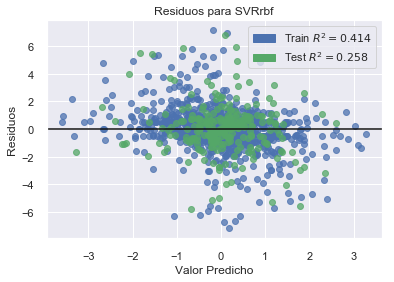

In [78]:
visualizer = ResidualsPlot(grid2.best_estimator_,title='Residuos para SVRrbf',hist=False)

visualizer.fit(X_train, y_train.values.ravel())  # Fit the training data to the model
visualizer.score(X_test, y_test.values.ravel())  # Evaluate the model on the test data

visualizer.finalize()
visualizer.ax.set_xlabel('Valor Predicho')
visualizer.ax.set_ylabel('Residuos')

#plt.savefig("SVRrbf_R2_train15.png",dpi=600,bbox_inches="tight")

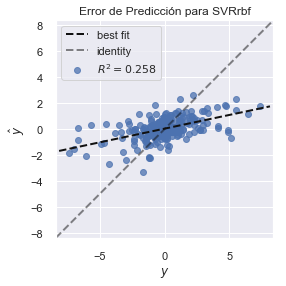

In [79]:
perror = PredictionError(grid2.best_estimator_, title='Error de Predicción para SVRrbf')

perror.fit(X_train, y_train.values.ravel())  # Fit the training data to the visualizer
perror.score(X_test, y_test.values.ravel())  # Evaluate the model on the test data

perror.finalize()
#plt.savefig("SVRrbf_PredictionError_train15.png",dpi=600,bbox_inches="tight")

#g = perror.poof()

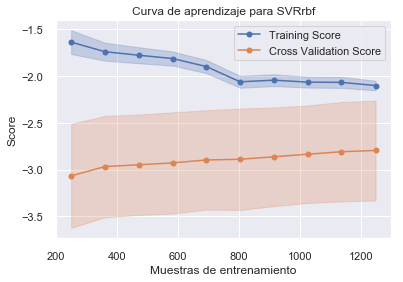

In [80]:
viz = LearningCurve(grid2.best_estimator_, cv=cv, n_jobs=-1,scoring='neg_mean_squared_error',
                    train_sizes=np.linspace(0.2, 1.0, 10),title='Curva de aprendizaje para SVRrbf')
viz.fit(full_data, y_full)

viz.finalize()

viz.ax.set_xlabel('Muestras de entrenamiento')
viz.ax.set_ylabel('Score')

plt.savefig("SVRrbf_LearningCurve_train15.png",dpi=600,bbox_inches="tight")

#viz.poof()

In [ ]:
np.sqrt(viz.test_scores_std_)

In [81]:
final_svr2 = grid2.best_estimator_.fit(full_data,y_full)
# save final model

joblib.dump(final_svr2, 'rbfSVRmodel_train15skempiAB_FINAL.pkl')

['rbfSVRmodel_train15skempiAB_FINAL.pkl']

# Poly kernel


In [114]:
#1)  ORIGINAL

## Pipeline preprocessing
interactions = FeaturesInteractions(interaction1=X_train.columns[:15].tolist(),interaction2="van_der_waals_change")
skewness = SkewTransformer(threshold=0.6,method='quantile')
zeroth = ZeroThreshold(threshold=90.)

scaler = MinMaxScaler()


#2)
linear_model = SVR()
#3) Crear pipeline
pipeline3 = make_pipeline(interactions,skewness,zeroth,scaler,linear_model)

# Use transformed target regressor
# regr_trans3 = TransformedTargetRegressor(regressor=pipeline3, 
#                                         transformer=QuantileTransformer(output_distribution='normal',random_state=13))


# grid params
# param_grid = { 'regressor__svr__kernel': ['poly'],'regressor__svr__C': [0.2,0.3,0.4],'regressor__svr__gamma': [0.3,0.4,0.5],
#               'regressor__svr__epsilon':[0.3,0.4,0.5],'regressor__svr__degree':[2] }
param_grid = { 'svr__kernel': ['poly'],'svr__C': [1.2],'svr__gamma': [0.4,0.5,0.6],
              'svr__epsilon':[0.4],'svr__degree':[2] }
cv = RepeatedKFold(n_splits=10,n_repeats=10,random_state=13)

# Instantiate the grid search model
grid3 = GridSearchCV(pipeline3, param_grid, verbose=5, n_jobs=-1,cv=cv,scoring=['neg_mean_squared_error','r2'],
                        refit='neg_mean_squared_error',return_train_score=True)

grid3.fit(X_train,y_train)

Fitting 100 folds for each of 3 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   26.7s finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x1a1bccb208>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('featuresinteractions', FeaturesInteractions(interaction1=['clash', 'covalent', 'vdw_clash', 'vdw', 'proximal', 'hbond', 'weak_hbond', 'xbond', 'ionic', 'metal_complex', 'aromatic', 'hydrophobic', 'carbonyl', 'polar', 'weak_polar'],
           interaction2='van_der_waals_change')), ('skewtra...
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'svr__kernel': ['poly'], 'svr__C': [1.2], 'svr__gamma': [0.4, 0.5, 0.6], 'svr__epsilon': [0.4], 'svr__degree': [2]},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score=True, scoring=['neg_mean_squared_error', 'r2'],
       verbose=5)

In [115]:
# index of best scores
rmse_bestCV_test_index = grid3.cv_results_['mean_test_neg_mean_squared_error'].argmax()
rmse_bestCV_train_index = grid3.cv_results_['mean_train_neg_mean_squared_error'].argmax()
r2_bestCV_test_index = grid3.cv_results_['mean_test_r2'].argmax()
r2_bestCV_train_index = grid3.cv_results_['mean_train_r2'].argmax()
# scores
rmse_bestCV_test_score = grid3.cv_results_['mean_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_test_std = grid3.cv_results_['std_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_train_score = grid3.cv_results_['mean_train_neg_mean_squared_error'][rmse_bestCV_train_index]
rmse_bestCV_train_std = grid3.cv_results_['std_train_neg_mean_squared_error'][rmse_bestCV_train_index]

r2_bestCV_test_score = grid3.cv_results_['mean_test_r2'][r2_bestCV_test_index]
r2_bestCV_test_std = grid3.cv_results_['std_test_r2'][r2_bestCV_test_index]
r2_bestCV_train_score = grid3.cv_results_['mean_train_r2'][r2_bestCV_train_index]
r2_bestCV_train_std = grid3.cv_results_['std_train_r2'][r2_bestCV_train_index]

print('CV test RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_test_score),np.sqrt(rmse_bestCV_test_std)))
print('CV train RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_train_score),np.sqrt(rmse_bestCV_train_std)))
print('DIFF RMSE {}'.format(np.sqrt(-rmse_bestCV_test_score)-np.sqrt(-rmse_bestCV_train_score)))

print('CV test r2 {:f} +/- {:f}'.format(r2_bestCV_test_score,r2_bestCV_test_std))
print('CV train r2 {:f} +/- {:f}'.format(r2_bestCV_train_score,r2_bestCV_train_std))

print(r2_bestCV_train_score-r2_bestCV_test_score)
print("",grid3.best_params_)
y_test_pred = grid3.best_estimator_.predict(X_test)
y_train_pred = grid3.best_estimator_.predict(X_train)
print("\nRMSE for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)))
print("RMSE for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)))
print("pearson corr  {:f}".format(np.corrcoef(y_test_pred,y_test.values.ravel())[0][1]))
print('R2 test',r2_score(y_test,y_test_pred))
print('R2 train',r2_score(y_train,y_train_pred))

CV test RMSE 1.715331 +/- 0.825285
CV train RMSE 1.496582 +/- 0.250058
DIFF RMSE 0.2187493017517823
CV test r2 0.159578 +/- 0.096601
CV train r2 0.366376 +/- 0.010297
0.2067973256213564
 {'svr__C': 1.2, 'svr__degree': 2, 'svr__epsilon': 0.4, 'svr__gamma': 0.5, 'svr__kernel': 'poly'}

RMSE for test dataset: 1.75
RMSE for train dataset: 1.54
pearson corr  0.478269
R2 test 0.22795041230340884
R2 train 0.33331055453312053


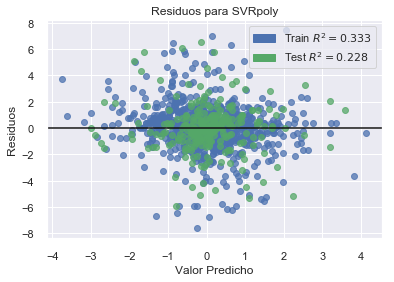

In [117]:
visualizer = ResidualsPlot(grid3.best_estimator_,title='Residuos para SVRpoly',hist=False)

visualizer.fit(X_train, y_train.values.ravel())  # Fit the training data to the model
visualizer.score(X_test, y_test.values.ravel())  # Evaluate the model on the test data

visualizer.finalize()
visualizer.ax.set_xlabel('Valor Predicho')
visualizer.ax.set_ylabel('Residuos')

plt.savefig("SVRpoly_R2_train15.png",dpi=600,bbox_inches="tight")

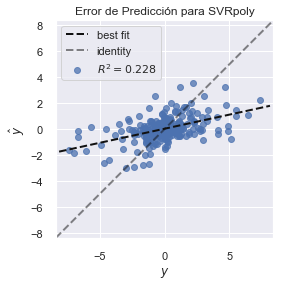

In [119]:
perror = PredictionError(grid3.best_estimator_, title='Error de Predicción para SVRpoly')

perror.fit(X_train, y_train.values.ravel())  # Fit the training data to the visualizer
perror.score(X_test, y_test.values.ravel())  # Evaluate the model on the test data

perror.finalize()
plt.savefig("SVRpoly_PredictionError_train15.png",dpi=600,bbox_inches="tight")

#g = perror.poof()

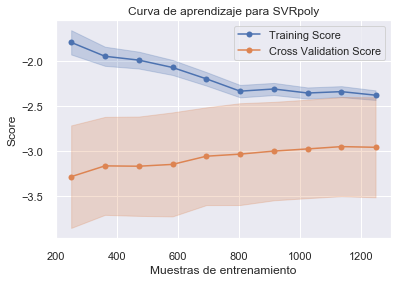

In [120]:
viz = LearningCurve(grid3.best_estimator_, cv=cv, n_jobs=-1,scoring='neg_mean_squared_error',
                    train_sizes=np.linspace(0.2, 1.0, 10),title='Curva de aprendizaje para SVRpoly')
viz.fit(full_data, y_full)

viz.finalize()

viz.ax.set_xlabel('Muestras de entrenamiento')
viz.ax.set_ylabel('Score')

plt.savefig("SVRpoly_LearningCurve_train15.png",dpi=600,bbox_inches="tight")

#viz.poof()

In [123]:
np.sqrt(viz.test_scores_std_)

array([0.7540336 , 0.73708697, 0.74225504, 0.75953148, 0.73629503,
       0.75141447, 0.73896167, 0.73902843, 0.7416378 , 0.74496147])

In [121]:
final_svr2 = grid2.best_estimator_.fit(full_data,y_full)
# save final model

joblib.dump(final_svr2, 'rbfSVRmodel_train15skempiAB_FINAL.pkl')


['rbfSVRmodel_train15skempiAB_FINAL.pkl']

In [122]:
final_svr3 = grid3.best_estimator_.fit(full_data,y_full)
# save final model

joblib.dump(final_svr3, 'poly2SVRmodel_train15skempiAB_FINAL.pkl')


['poly2SVRmodel_train15skempiAB_FINAL.pkl']